In [273]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy as sp
from tensorflow.keras import layers
from scipy.integrate import odeint

In [321]:
# Define a non-linear dynamical system (example: Lorenz system)
def van_der_pol(t, x):
    mu = 3
    dxdt = x[1]
    dydt = mu * (1 - x[0]**2) * x[1] - x[0]
    return [dxdt, dydt]

In [322]:
# Generate time-series data from the non-linear system
timesteps = np.linspace(0, 10, 1000)
x0 = np.array([0.5, 0.0])  # Updated initial condition
# data = []
# x = x0
# for t in timesteps[:-1]:  # Exclude the last timestep
#     data.append(x)
#     k1 = duffing_oscillator(x, t)
#     k2 = duffing_oscillator(x + 0.5 * k1, t + 0.5)
#     k3 = duffing_oscillator(x + 0.5 * k2, t + 0.5)
#     k4 = duffing_oscillator(x + k3, t + 1.0)
#     x = x + (k1 + 2 * k2 + 2 * k3 + k4) * (1/6) * 0.01
data = odeint(van_der_pol, x0, t=timesteps, tfirst = True)

data = np.array(data)
print(data)

[[ 0.5         0.        ]
 [ 0.49997475 -0.00506173]
 [ 0.49989828 -0.01023821]
 ...
 [-2.01882463  0.10847556]
 [-2.01768932  0.11821074]
 [-2.01646089  0.12709316]]


In [323]:
# Define the Koopman operator neural network
model = tf.keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(4, activation = 'relu'),
    layers.Dense(4, activation = 'linear'),        # The Koopman operator predicts the state at the next time step
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(2),
])

In [324]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Split data into input and output
X = data[:-1]
y = data[1:]


In [325]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_215 (Dense)           (None, 128)               384       
                                                                 
 dense_216 (Dense)           (None, 64)                8256      
                                                                 
 dense_217 (Dense)           (None, 32)                2080      
                                                                 
 dense_218 (Dense)           (None, 4)                 132       
                                                                 
 dense_219 (Dense)           (None, 4)                 20        
                                                                 
 dense_220 (Dense)           (None, 32)                160       
                                                                 
 dense_221 (Dense)           (None, 64)              

In [326]:
# Train the Koopman operator
model.fit(X, y, epochs=100, verbose=1)


Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 1.6404
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5925
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2747
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0625
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 11/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 12/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 13/100
32/32 [=================

In [330]:
linear_layer_weights = model.layers[-5].get_weights()[0]
print("Linear Layer Weights (Koopman Operators):\n", linear_layer_weights)

Linear Layer Weights (Koopman Operators):
 [[ 0.78117687 -0.4005713   0.32135096  0.7450857 ]
 [ 0.37719056  0.6350642   0.43564186  0.47469696]
 [-0.41941515  0.61414814  0.539199    0.6412569 ]
 [-0.37140524  0.14613983  0.78170574 -0.7095174 ]]


32/32 [==============================] - 0s 2ms/step
(1000,)
(999, 2)


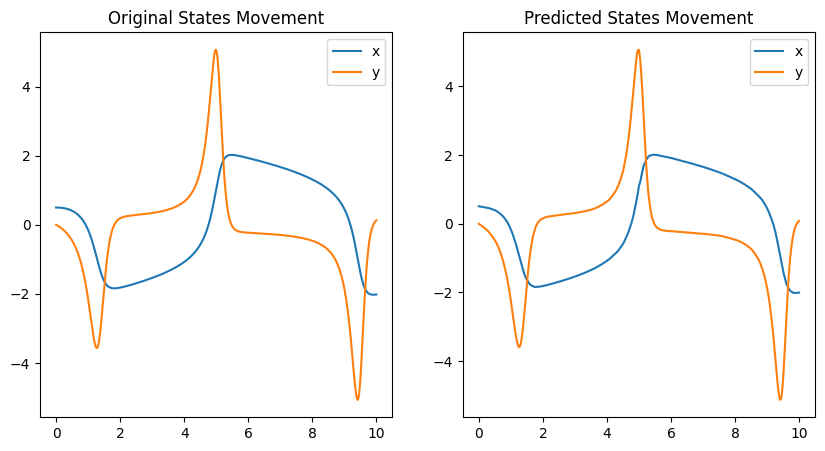

In [331]:
# Generate predictions from the Koopman operator
predictions = model.predict(X)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Original States Movement')
plt.plot(timesteps[:], data[:, 0], label='x')
plt.plot(timesteps[:], data[:, 1], label='y')
plt.legend()
print(timesteps.shape)
print(predictions.shape)
plt.subplot(122)
plt.title('Predicted States Movement')
plt.plot(timesteps[:-1], predictions[:, 0], label='x')
plt.plot(timesteps[:-1], predictions[:, 1], label='y')
plt.legend()

plt.show()

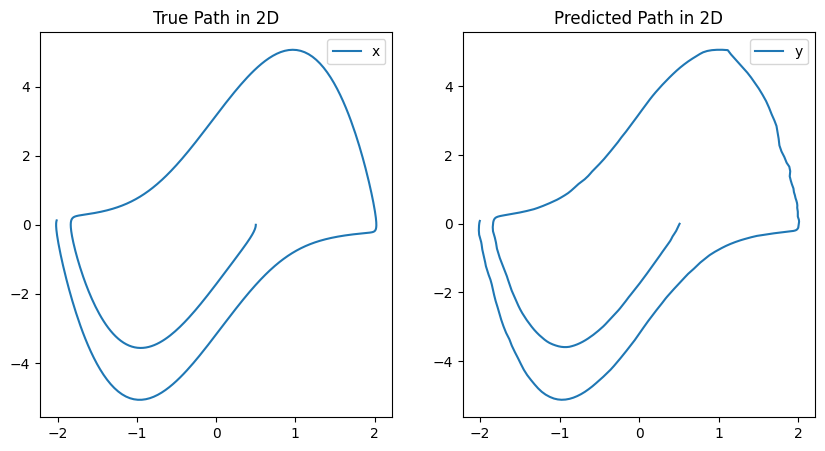

In [332]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('True Path in 2D')
plt.plot(data[:, 0], data[:, 1], label='x')
plt.legend()

plt.subplot(122)
plt.title('Predicted Path in 2D')
plt.plot(predictions[:, 0], predictions[:, 1], label='y')
plt.legend()

plt.show()